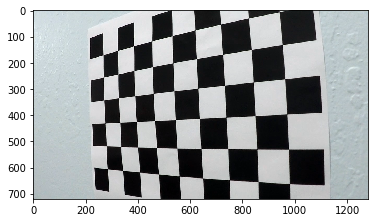

Points not found for img ../camera_cal/calibration4.jpg 


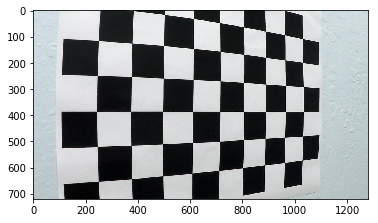

Points not found for img ../camera_cal/calibration5.jpg 


In [315]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images[1:]:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #plt.imshow(img)
        #plt.show()
        #cv2.waitKey(500)
    else:
        plt.imshow(img)
        plt.show()
        print ('Points not found for img %s ' % fname)

#cv2.destroyAllWindows()

ret, mtx, dist, rvecs, tvecs \
= cv2.calibrateCamera(objpoints, imgpoints, img.shape[:2], None, None)

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

In [316]:
#src=np.float32([[525,500],[img.shape[1]-515,500],[img.shape[1]-235,680],[260,680]])
src=np.float32([[592+2,450],[690-2,450],[img.shape[1]-235,680],[270,680]])

offset=250

dst=np.float32([[offset,offset],[img.shape[1]-offset,offset],\
     [img.shape[1]-offset,img.shape[0]],[offset,img.shape[0]]])

src = np.float32 ([
        [220, 651],
        [350, 577],
        [828, 577],
        [921, 651]
    ])

dst = np.float32 ([
        [220, 651],
        [220, 577],
        [921, 577],
        [921, 651]
    ])


#dst=np.float32([[offset,offset],[img.shape[1]-offset,offset],\
#     [img.shape[1]-offset,img.shape[0]-offset],[offset,img.shape[0]-offset]])

M=cv2.getPerspectiveTransform(src,dst)
Minv=cv2.getPerspectiveTransform(dst,src)


def pr(img):
    return cv2.warpPerspective(img[:690],M, (img.shape[1],690), flags=cv2.INTER_LINEAR)

def pr_r(img):
    return cv2.warpPerspective(img,Minv, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)




def fit_poly (binary_warped, verbose=False):

    #binary_warped = pr(binarize(img))

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom 1/4 of the image
    histogram = np.sum(binary_warped[int(3*binary_warped.shape[0]/4):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    #left and right centers
    left_centers=[]
    right_centers=[]

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image

        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            left_centers.append(leftx_current)
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            right_centers.append(rightx_current)

    #get lines direction
    left_dir=np.array(right_centers)[:-1]-np.array(right_centers)[1:]
    right_dir=np.array(right_centers)[:-1]-np.array(right_centers)[1:]
    direction = np.concatenate([left_dir, right_dir]).mean()

    #if direction<-20:
    #    good_left=np.where(left_dir<0)[0]
    #    good_right=np.where(right_dir<0)[0]
    #elif direction>20:
    #    good_left=np.where(left_dir>0)[0]
    #    good_right=np.where(right_dir>0)[0]
    if True:
        good_left=range(len(left_dir))
        good_right=range(len(right_dir))
        
    t=300
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate([left_lane_inds[a] for a in good_left\
                                   if len(left_lane_inds[a])>t])
    right_lane_inds = np.concatenate([right_lane_inds[a]  for a in good_right\
                                    if len(right_lane_inds[a])>t])
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    if verbose:
        fig,ax=plt.subplots(1,2)
        fig.set_figheight(10)
        fig.set_figwidth(15)

        ax[0].imshow(out_img)

        ax[1].imshow(binary_warped,cmap='gray')
        ax[1].plot(left_fitx, ploty, color='yellow')
        ax[1].plot(right_fitx, ploty, color='yellow')
        ax[1].set_xlim(0, 1280)
        ax[1].set_ylim(720, 0)
        plt.show()
    return left_fit, right_fit

In [227]:
import glob

gl=glob.glob('harder/*.png')+glob.glob('project/*.png')

In [228]:
%%sh 
rm projected/*

In [10]:
img=cv2.imread(gl[0])

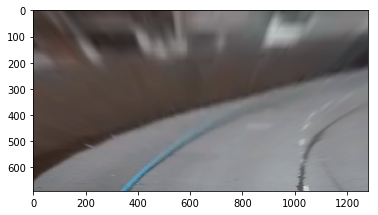

In [13]:
plt.imshow(pr(undistort(img)))

In [229]:
sample=np.random.choice(gl,300,replace=False)

In [230]:
from tqdm import tqdm_notebook

for a in tqdm_notebook(sample):
    img=cv2.imread(a)
    cv2.imwrite('projected/'+a.split('/')[-1],pr(undistort(img)))

In [24]:
gl=glob.glob('../test_images/*')

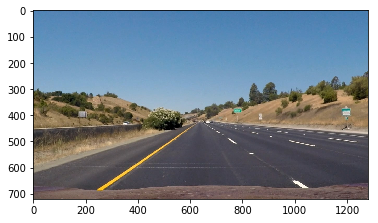

In [25]:
img=mpl.image.imread(gl[0])
plt.imshow(img)

In [26]:
def binarize(img, s_thresh=(120, 255), sx_thresh=(20, 255),l_thresh=(40,255)):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    #h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    # sobelx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255))
    # l_channel_col=np.dstack((l_channel,l_channel, l_channel))
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Threshold lightness
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    channels = 255*np.dstack(( l_binary, sxbinary, s_binary)).astype('uint8')        
    binary = np.zeros_like(sxbinary)
    binary[((l_binary == 1) & (s_binary == 1) | (sxbinary==1))] = 1
    #binary = 255*np.dstack((binary,binary,binary)).astype('uint8')            
    return  np.uint8(binary)

In [31]:
tmp=binarize(pr(undistort(img)))

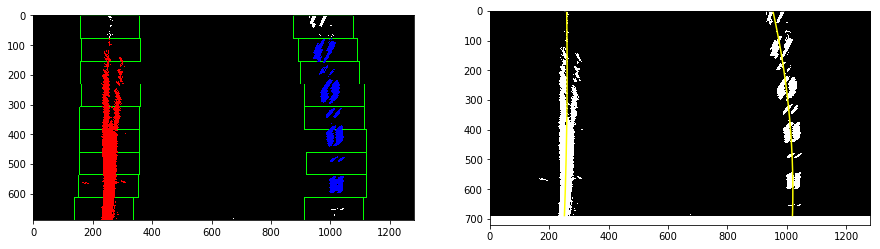

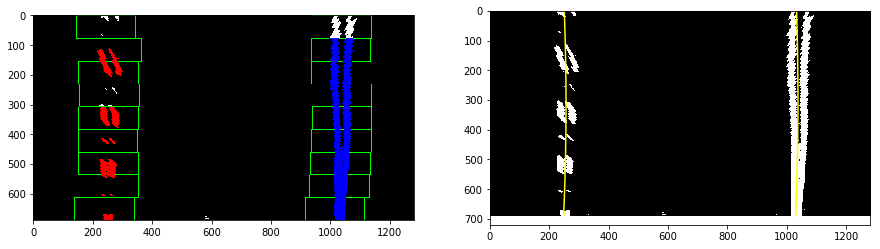

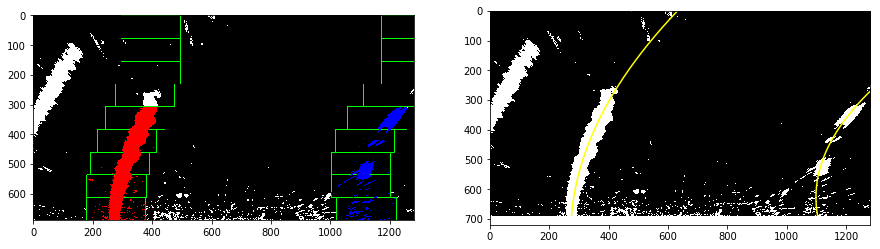

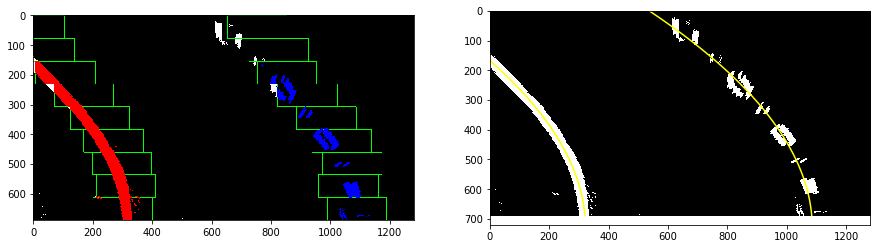

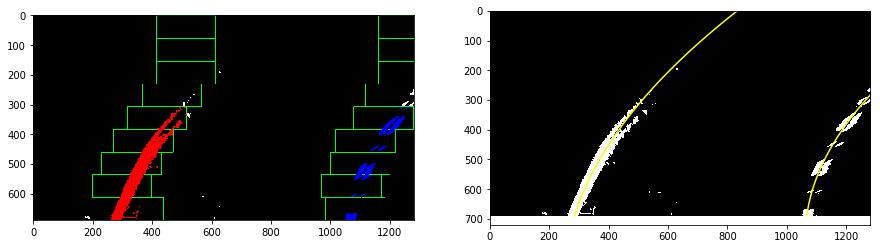

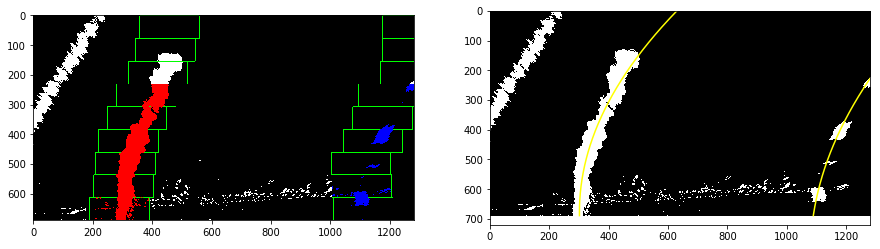

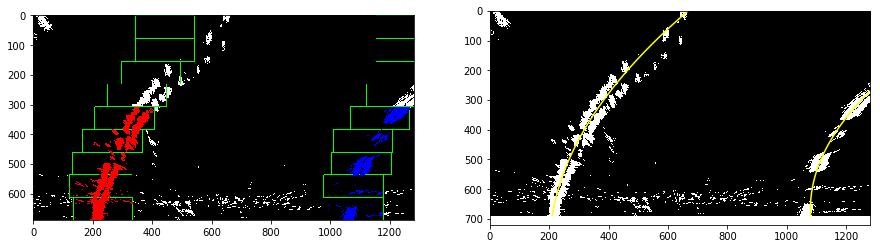

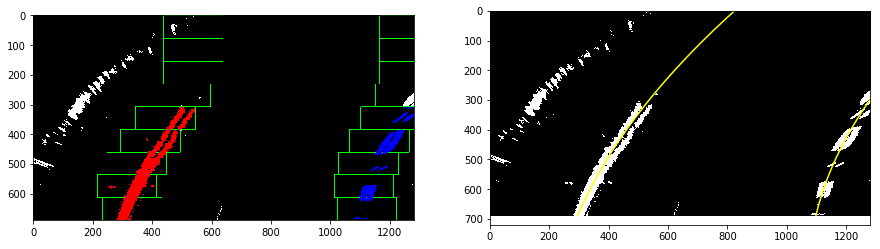

In [36]:
all_lines=[]

for fname in gl:
    img=cv2.imread(fname)
    tmp=binarize(pr(undistort(img)))
    lines=np.array(fit_poly(tmp,verbose=True))
    all_lines.append(lines)

In [38]:
q=np.array([a[0]-a[1] for a in all_lines])

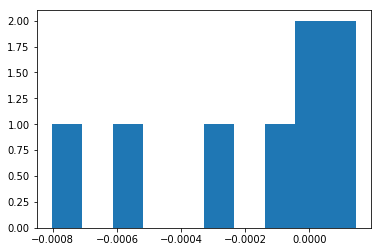

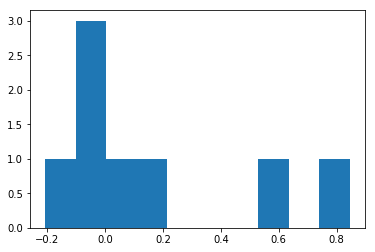

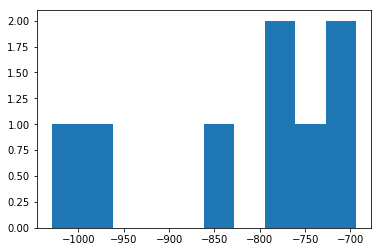

In [43]:
plt.hist(q[:,0])
plt.show()

plt.hist(q[:,1])
plt.show()

plt.hist(q[:,2])
plt.show()

In [69]:
def check_lines(lines):
    div=lines[0]-lines[1]
    if abs(div[0])<0.001 and abs(div[1])<1 and div[2]<-600 and div[2]>-1100:
        return True
    return False

In [57]:
np.abs(q).max(axis=0).tolist()

[0.000802899082003332, 0.845397019289585, 1029.334270951292]

In [78]:
gl=glob.glob('projected/*.png')

In [88]:
%%time
all_lines=[]

for fname in gl[:10]:
    img=mpl.image.imread(fname)
    #plt.imshow(img)
    #plt.show()
    tmp=binarize(img)
    lines=np.array(fit_poly(tmp,verbose=False))
    if check_lines(lines):
        print ('yes!')
    all_lines.append(lines)

yes!
yes!
yes!
yes!
CPU times: user 1.16 s, sys: 389 ms, total: 1.55 s
Wall time: 1.48 s


In [247]:
def get_channel(img,channel):
    # take needed channel
    if channel=='gray':
        channel = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if channel in ('h','l','s'):
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        if channel=='h':
            channel = hls[:,:,0]
        elif channel=='l':
            channel = hls[:,:,1] 
        else:
            channel = hls[:,:,2]
    if channel in ('L','A','B'):
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        if channel=='L':
            channel = hls[:,:,0]
        elif channel=='A':
            channel = hls[:,:,1] 
        else:
            channel = hls[:,:,2]
    return channel

def abs_sobel_thresh(img, orient='x', channel='gray',thresh=(0,255),normalize=False,\
                    sobel_kernel=5):
    # take needed channel
    gray=get_channel(img,channel)
        
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255),channel='gray',normalize=False):
    
    # Convert to grayscale
    gray=get_channel(img,channel)
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return np.uint8(binary_output)

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2),channel='gray',normalize=False):
    # Grayscale
    gray=get_channel(img,channel)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return np.uint8(binary_output)

def channel_select(img, thresh=(0, 255), channel='gray', normalize=False):
    gray=get_channel(img,channel)
    if normalize:
        gray = gray*(255/gray.max())
    binary_output = np.zeros_like(gray)
    binary_output[(gray > thresh[0]) & (gray <= thresh[1])] = 1
    return np.uint8(binary_output)

functions={'abs_sobel_thresh':abs_sobel_thresh,\
            'mag_thresh':mag_thresh,
            'dir_threshold':dir_threshold,
            'channel_select':channel_select}

def transform_f(params):
    params0=deepcopy(params)
    fname=params0.pop('fname')
    return functions[fname](**params0)

def transform (img, params, operation='max'):
    res=np.zeros(tuple([len(params)]+list(img.shape)[:2]), dtype=np.uint8)
    for i, param in enumerate(params):
        param['img']=img
        res[i]=transform_f(param)
    if operation=='max':
        return res.max(axis=0)
    return res.min(axis=0)
        

In [192]:
from copy import deepcopy
def check_params(img,params):
    img_t=transform(img,params)
    lines=fit_poly(img_t,verbose=False)
    return check_lines(lines)

def check_imgs(imgs,params):
    return sum([check_params(a,deepcopy(params)) for a in imgs])

In [195]:
from itertools import product


params_greed=[a for a in \
              product(range(0,100,20),range(0,100,5),range(0,100,5),range(0,100,5))]

imgs=[mpl.image.imread(a) for a in gl[:10]]

In [197]:
%%time

res=[]

for a in tqdm_notebook(params_greed):
    params=[
        {'fname':'abs_sobel_thresh','orient':'x','channel':'l','thresh':(abs_treshs[0],255)},
        {'fname':'abs_sobel_thresh','orient':'x','channel':'s','thresh':(abs_treshs[1],255)},
        {'fname':'abs_sobel_thresh','orient':'x','channel':'A','thresh':(abs_treshs[2],255)},
        {'fname':'abs_sobel_thresh','orient':'x','channel':'B','thresh':(abs_treshs[3],255)},
    ]

    res.append(check_imgs(imgs,params))

/Users/p.tarasov/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:13: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  del sys.path[0]


KeyboardInterrupt: 

In [189]:
abs_treshs=[20,20,20,20]

params=[
        {'fname':'abs_sobel_thresh','orient':'x','channel':'l','thresh':(abs_treshs[0],255)},
        {'fname':'abs_sobel_thresh','orient':'x','channel':'s','thresh':(abs_treshs[1],255)},
        {'fname':'abs_sobel_thresh','orient':'x','channel':'A','thresh':(abs_treshs[2],255)},
        {'fname':'abs_sobel_thresh','orient':'x','channel':'B','thresh':(abs_treshs[3],255)},
    ]

#check_params(img,params)

In [140]:
abs_sobelx_my = abs_sobel_thresh(img, orient='x', channel='l',thresh=sx_thresh)
s_binary_my=channel_select(img, channel='s', thresh=s_thresh)
l_binary_my=channel_select(img, channel='l', thresh=l_thresh)

binary_my=(l_binary_my*s_binary_my)|sxbinary

/Users/p.tarasov/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:13: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  del sys.path[0]


In [141]:
abs_sobelx_my2==abs_sobelx_my

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ..., 
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], dtype=bool)

In [116]:
255/5

51.0

In [119]:
img.shape

(690, 1280, 3)

In [135]:
params.pop('fname')

'abs_sobel_thresh'

In [136]:
params

{'channel': 'l', 'img': array([[[ 0.36078432,  0.33333334,  0.32156864],
         [ 0.36078432,  0.33333334,  0.32156864],
         [ 0.36078432,  0.33333334,  0.32156864],
         ..., 
         [ 0.39215687,  0.35294119,  0.34509805],
         [ 0.39215687,  0.35294119,  0.34509805],
         [ 0.39215687,  0.35294119,  0.34509805]],
 
        [[ 0.36078432,  0.33333334,  0.32156864],
         [ 0.36078432,  0.33333334,  0.32156864],
         [ 0.36078432,  0.33333334,  0.32156864],
         ..., 
         [ 0.39215687,  0.35294119,  0.34509805],
         [ 0.39215687,  0.35294119,  0.34509805],
         [ 0.39215687,  0.35294119,  0.34509805]],
 
        [[ 0.36078432,  0.33333334,  0.32156864],
         [ 0.36078432,  0.33333334,  0.32156864],
         [ 0.36078432,  0.33333334,  0.32156864],
         ..., 
         [ 0.39215687,  0.35294119,  0.34509805],
         [ 0.39215687,  0.35294119,  0.34509805],
         [ 0.39215687,  0.35294119,  0.34509805]],
 
        ..., 
        [

/Users/p.tarasov/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:13: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  del sys.path[0]


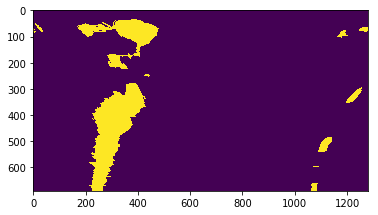

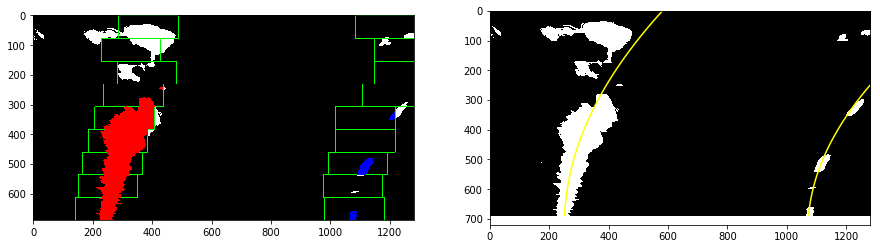

True

In [226]:
params=[
        {'fname':'channel_select','channel':'s','thresh':(80,255),'normalize':True},
        {'fname':'channel_select','channel':'B','thresh':(80,255),'normalize':True},
    ]
tmp=transform(img,params)
plt.imshow(tmp)

check_lines(fit_poly(tmp,verbose=True))

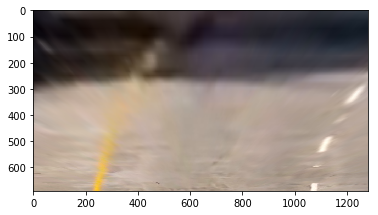

/Users/p.tarasov/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:13: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  del sys.path[0]


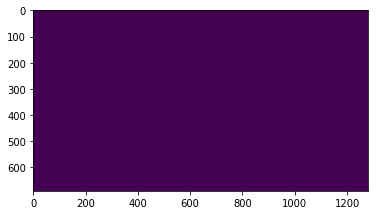

In [211]:
img=deepcopy(imgs[3])

plt.imshow(img)
plt.show()
plt.imshow(transform(img,params))
plt.show()

In [231]:
gl=glob.glob('projected/*')

In [233]:
imgs=[mpl.image.imread(a) for a in gl]

In [236]:
import random
random.shuffle(imgs)

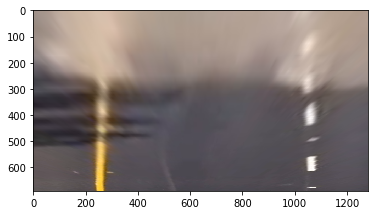

/Users/p.tarasov/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:13: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  del sys.path[0]
/Users/p.tarasov/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:94: RuntimeWarning: Mean of empty slice.
/Users/p.tarasov/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


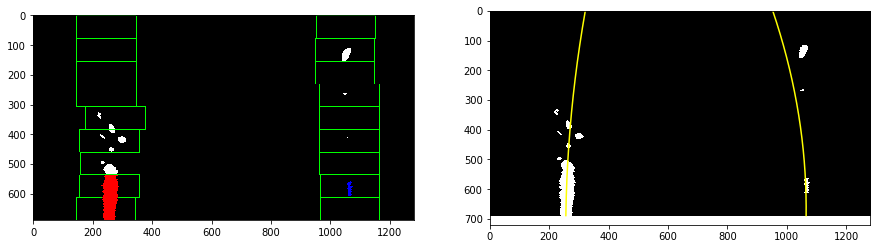

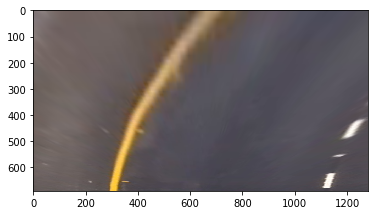

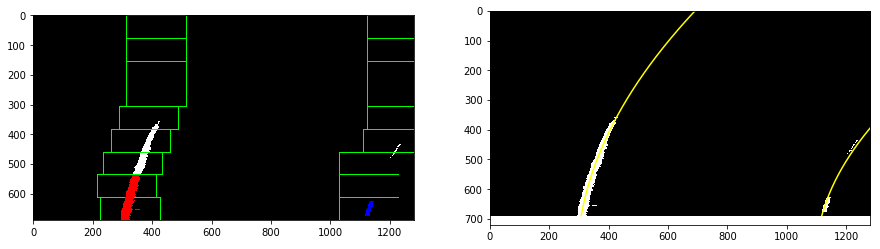

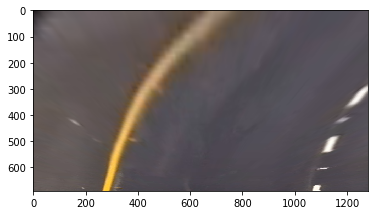

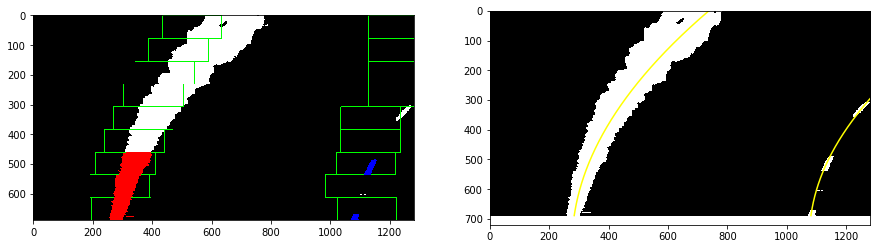

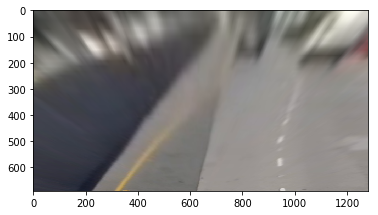

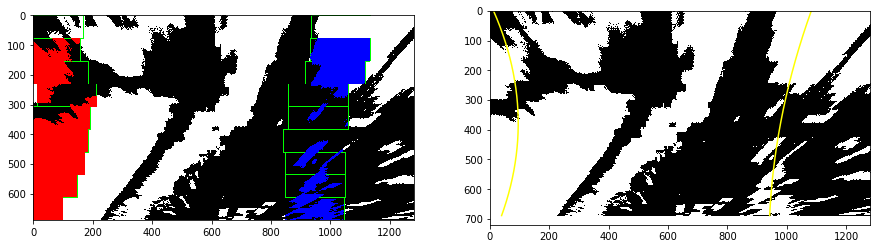

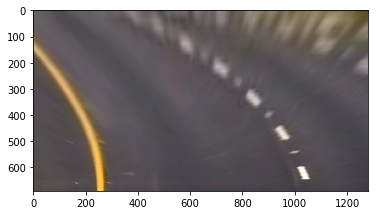

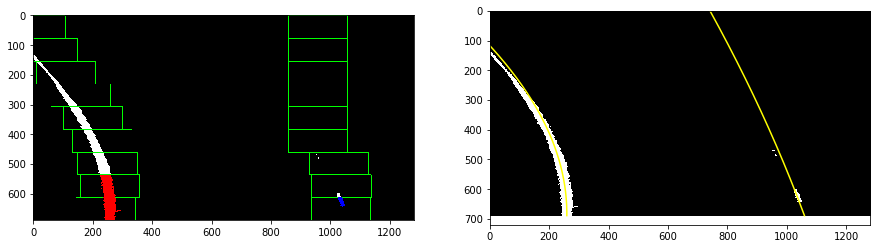

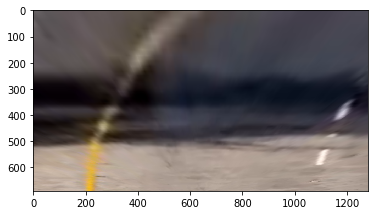

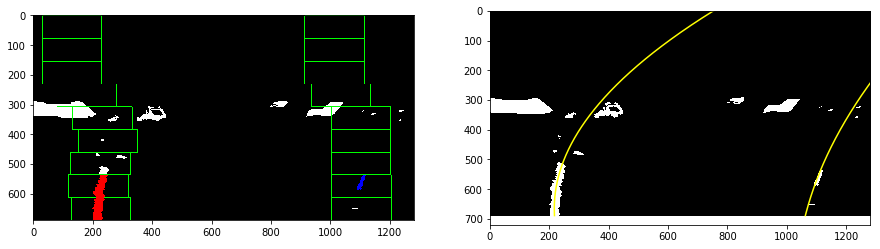

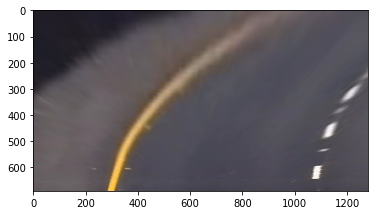

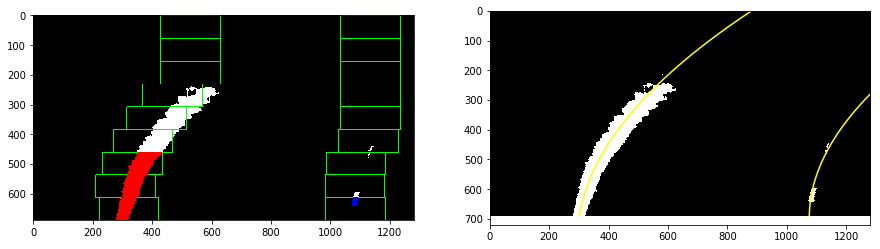

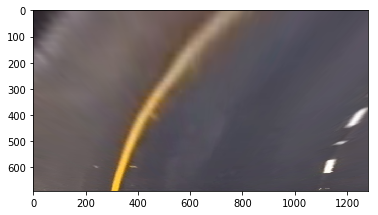

fuck!


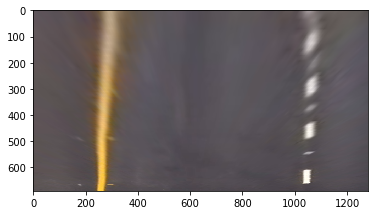

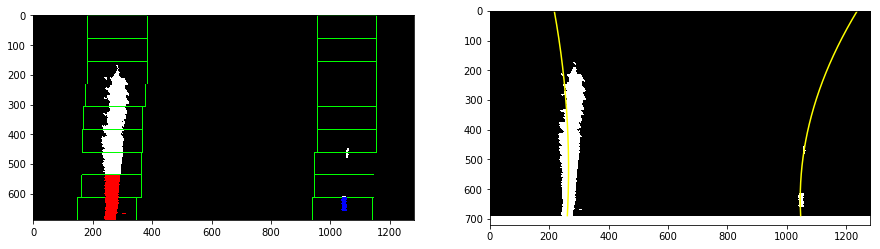

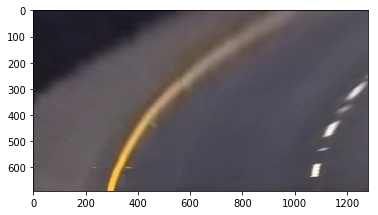

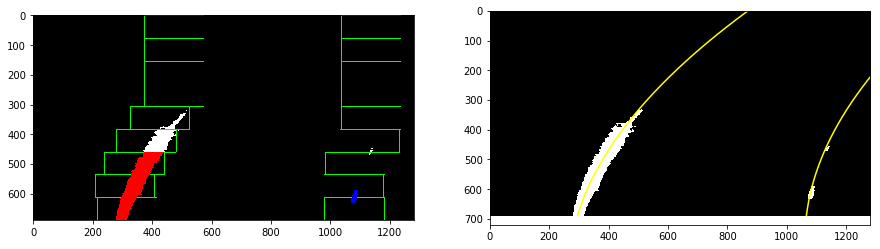


36/|/ 72%|| 36/50 [00:20<00:07,  1.79it/s]

In [244]:
for img in tqdm_notebook(imgs[:10],desc='images'):
    plt.imshow(img)
    plt.show()
    good=False
    for tr in tqdm_notebook(range(0,250,5),desc='tr loop'):
        params=[
        {'fname':'channel_select','channel':'s','thresh':(250-tr,255),'normalize':True},
        {'fname':'channel_select','channel':'B','thresh':(250-tr,255),'normalize':True},
        ]
        tmp=transform(img,params)
        
        try:
            res=check_lines(fit_poly(tmp,verbose=False))
        except:
            res=False
        
        if res:
            good=True
            fit_poly(tmp,verbose=True)
            break
    if not good:
        print ('fuck!')

In [242]:
abs_sobelx_my = abs_sobel_thresh(img, orient='x', channel='l',thresh=sx_thresh)
s_binary_my=channel_select(img, channel='s', thresh=s_thresh)
l_binary_my=channel_select(img, channel='l', thresh=l_thresh)

binary_my=(l_binary_my*s_binary_my)|sxbinary

Help on function tqdm_notebook in module tqdm:

tqdm_notebook(*args, **kwargs)
    See tqdm._tqdm_notebook.tqdm_notebook for full documentation



In [266]:
def binarize(src,ksize=5):
    # horizontal part of gradient
    gradx = abs_sobel_thresh(src, orient='x', sobel_kernel=3, thresh=(1, 120))
    # vertical part of gradient
    grady = abs_sobel_thresh(src, orient='y', sobel_kernel=3, thresh=(1, 120))
    # magnitude of gradient
    mag_binary = mag_thresh(src, sobel_kernel=1, thresh=(30, 100))
    # left line angle filtered gradient
    dir_binary_l = dir_threshold(src, sobel_kernel=ksize, thresh=(35*np.pi/180, 65*np.pi/180))
    # right line angle filtered gradient
    dir_binary_r = dir_threshold(src, sobel_kernel=ksize, thresh=(-65*np.pi/180, -35*np.pi/180))
    
    combined = np.zeros_like(src)
    # thresholding based on gradient combination
    combined[(
            ((gradx == 1) & (grady == 1)) | 
            (
                (mag_binary == 1) &
                ((dir_binary_l == 1) | (dir_binary_r == 1))
            )
        )] = 1
    return combined

/Users/p.tarasov/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """
/Users/p.tarasov/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:13: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  del sys.path[0]


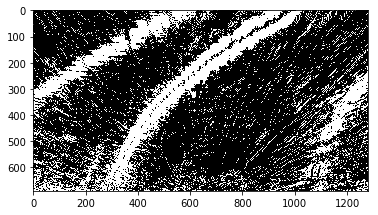

In [267]:
plt.imshow(binarize(img))

In [291]:
np.pi/2

1.5707963267948966

/Users/p.tarasov/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """
/Users/p.tarasov/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:13: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  del sys.path[0]


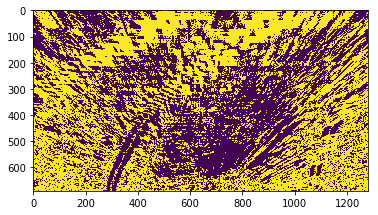

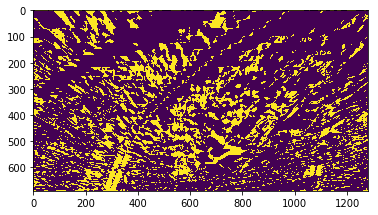

In [305]:
ksize=5
dir_binary_r = dir_threshold(img, sobel_kernel=ksize,\
                             thresh=( np.pi/4, np.pi/2-0.001))
plt.imshow(dir_binary_r)
plt.show()

ksize=5
dir_binary_r = dir_threshold(img, sobel_kernel=31,\
                             thresh=( 0, np.pi/6))
plt.imshow(dir_binary_r)

In [307]:
gl=glob.glob('harder/*.png')

In [308]:
random.shuffle(gl)

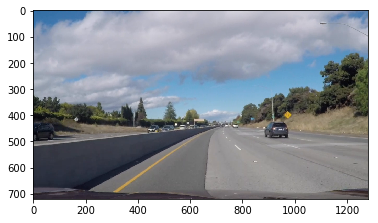

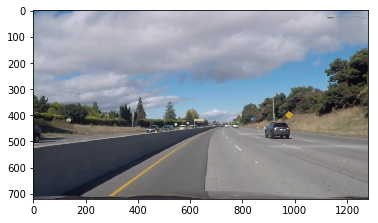

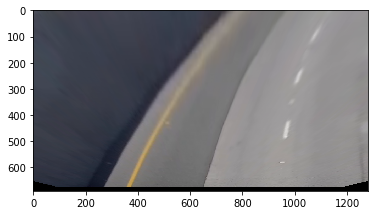

In [317]:
imgt=mpl.image.imread(gl[1])
plt.imshow(((imgt)))
plt.show()
plt.imshow((undistort(imgt)))
plt.show()
plt.imshow(pr(undistort(imgt)))
plt.show()

In [282]:

def get_s_from_hls (img):
    hls = cv2.cvtColor (img, cv2.COLOR_BGR2HLS)
    return hls [:,:,2]

def morphology_filter (image):
    """Filtering lane lines with "opening" morphology operation
    
        1. Taking linear combination of
            HLS S layer * 0.6 + Grayscaled image * 0.4
    
        2. Applying opening, as a result we have image with erased lane lines 
        
        3. Subtracting image without lane lines from original image and
            returning lane lines
    
    Args:
        image (np.array): color image in BGR format
    Returns:
        np.array: graysacle image with filtered lane lines along with some another parts of the image
    """
    
    gray = cv2.cvtColor (image, cv2.COLOR_BGR2GRAY)
    hls_s = get_s_from_hls (image)
    src = hls_s# * 0.6 + gray * 0.4

    src = np.array( src / 255.).astype ('float32') - 0.5

    blurf = np.zeros((1, 5))
    blurf.fill (1)
    src = cv2.filter2D(src, cv2.CV_32F, blurf)

    f = np.zeros((1, 30))
    f.fill (1)
    l = cv2.morphologyEx(src, cv2.MORPH_OPEN, f)

    filtered = src - l
    return filtered

# image = cv2.imread ('challenge_image.png')
# image = cv2.imread ('signs_vehicles_xygrad.jpg')
#image = cv2.imread ('test_images/test4.jpg')
image = undistort(img)
#cv2.undistort(image, camera_matrix, dist_coeffs, None, camera_matrix)

mf =  morphology_filter (image)



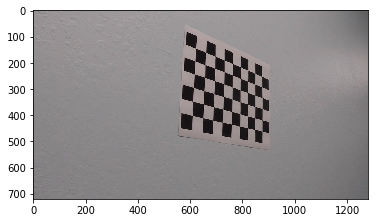

In [319]:
plt.imshow(img)
plt.show()

In [318]:
tmp=pr

(array([ -2.68876484e-04,   9.05350732e-02,   1.59561289e+02]),
 array([ -1.97841490e-05,  -9.70064121e-02,   7.69963344e+02]))

In [ ]:
warped_straight_lines.jpg

y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)